In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import copy
import os
from datetime import datetime

<img src="architecture.JPG" width=1000>

## ProGAN Modules

In [2]:
class MinibatchStdDev(nn.Module):
    def __init__(self, in_channels, group_size=4, epsilon=1e-8):
        super().__init__()

        self.in_channels = in_channels
        self.group_size = group_size
        self.epsilon = epsilon
    
    def forward(self, x):
        assert self.group_size <= x.shape[0]

        B, C, H, W = x.shape

        y = x.view(self.group_size, -1, C, H, W)              # GMCHW
        y = y - y.mean(dim=0, keepdim=True)                   # GMCHW
        y = torch.sqrt(y.square().mean(dim=0) + self.epsilon) # MCHW
        y = y.mean(dim=[1, 2, 3], keepdim=True)               # M111
        y = y.repeat(self.group_size, 1, H, W)                # B1HW
        y = torch.cat([x, y], dim=1)                          # B(C+1)HW

        return y


class EqualizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)
    

class EqualizedConvTranspose2d(nn.ConvTranspose2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv_transpose2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)


class EqualizedLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/in_features)
    
    def forward(self, x):
        return F.linear(x, self.weight * self.scale, self.bias)


class PixelwiseFeatureVectorNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()

        self.epsilon = epsilon

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [3]:
def is_power_of_two(num):
    return (num & (num - 1)) == 0 and num != 0

def get_num_of_steps_from_image_size(image_size):
    return int(np.log2(image_size) - 1)

## Discriminator

In [4]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            MinibatchStdDev(in_channels=in_channels),
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(2),
        )

    def forward(self, x):
        
        return self.net(x)


DiscriminatorBlock(in_channels=35, out_channels=64)(x=torch.randn(4, 35, 512, 512)).shape

torch.Size([4, 64, 256, 256])

In [5]:
class DiscriminatorFinalBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            MinibatchStdDev(in_channels=in_channels),
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(in_channels, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(1)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_size=1024, image_channels=3, steps_in_channels=[16, 32, 64, 128, 256, 512, 512, 512, 512]):
        super().__init__()
        
        self.image_size = image_size
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_in_channels) == self.num_steps

        self.net = nn.ModuleList([
            DiscriminatorBlock(
                in_channels if idx == 0 else in_channels + image_channels,
                out_channels
            ) for idx, (in_channels, out_channels) in enumerate(zip(steps_in_channels[:-1], steps_in_channels[1:]))
        ])
        self.net.append(DiscriminatorFinalBlock(steps_in_channels[-1] + image_channels))

        self.from_rgb = EqualizedConv2d(image_channels, steps_in_channels[0], kernel_size=1, stride=1, padding=0)

    def forward(self, images):
        assert len(images) == self.num_steps

        x = self.from_rgb(images[0])
        for step in range(self.num_steps):
            x = self.net[step](x if step == 0 else torch.cat((x, images[step]), dim=1))

        return x


print(
    Discriminator(
        image_size=32, image_channels=3, steps_in_channels=[16, 32, 64, 128]
    )(images=[
        torch.randn((4, 3, 32, 32)),
        torch.randn((4, 3, 16, 16)),
        torch.randn((4, 3, 8, 8)),
        torch.randn((4, 3, 4, 4)),
    ]).shape
)

torch.Size([4])


## Generator

In [7]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization(),
            EqualizedConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization(),
        )

    def forward(self, x):
        return self.net(x)


class GeneratorInitialBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            PixelwiseFeatureVectorNormalization(),
            EqualizedConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization()
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=512, image_size=1024, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16]):
        super().__init__()
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_out_channels) == self.num_steps - 1

        self.net = nn.ModuleList([GeneratorInitialBlock(z_dim)])

        steps_in_channels = [z_dim] + steps_out_channels[:-1]
        for in_channels, out_channels in zip(steps_in_channels, steps_out_channels):
            self.net.append(GeneratorBlock(in_channels, out_channels))

        self.to_rgb = nn.ModuleList([
            EqualizedConv2d(channels, image_channels, kernel_size=1, stride=1, padding=0) for channels in [z_dim] + steps_out_channels
        ])


    def forward(self, z):
        images = []

        x = z
        for step in range(self.num_steps):
            x = self.net[step](x)
            images.insert(0, self.to_rgb[step](x))

        return images


print([img.shape for img in Generator(z_dim=128, image_size=32, image_channels=3, steps_out_channels=[64, 32, 16])(torch.randn(4, 128, 1, 1))])

[torch.Size([4, 3, 32, 32]), torch.Size([4, 3, 16, 16]), torch.Size([4, 3, 8, 8]), torch.Size([4, 3, 4, 4])]


## Training

In [9]:
def update_exponential_moving_average_generator(ema_gen, gen, decay=0.999):
    gen_named_parameters = dict(gen.named_parameters())
    with torch.no_grad():
        for param_name, param in ema_gen.named_parameters():
            param.copy_(param * decay + (1. - decay) * gen_named_parameters[param_name])

In [10]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [11]:
def build_pyramid_image(images):
    max_size = images[0].shape[1]
    min_size = images[-1].shape[1]
    img_channels = 1
    out = torch.ones(img_channels, max_size*2 - min_size, max_size, dtype=torch.float)

    margin_from_top = out.shape[1]
    for x in images:
        margin_from_top -= x.shape[1]
        out[:, margin_from_top:margin_from_top+x.shape[1], :x.shape[2]] = (x + 1) / 2
    
    return out.detach().clip(0, 1)

In [12]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

a = np.random.uniform(10, 25, 5)
print(a)
print(AdjustPixelsRange((10, 20), (0, 1))(a).tolist())

[21.16419207 23.28075703 10.95357268 12.00904269 16.54885649]
[1.0, 1.0, 0.09535728436102175, 0.20090428688980655, 0.6548856738335114]


In [13]:
def calc_gradient_penalty(critic, real_images, fake_images, device):
    eps = torch.rand((real_images[0].size(0), *(1 for _ in range(len(real_images[0].shape) - 1)))).to(device)

    intermediate_images = [eps * real_images[i] + (1 - eps) * fake_images[i] for i in range(len(real_images))]
    for intermediate_image in intermediate_images:
        intermediate_image.requires_grad = True

    scores = critic(intermediate_images)
    
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)
    
    gp = 0.
    for g in gradients:
        gradients_norm = torch.norm(g.view(g.shape[0], -1), dim=1)
        gp += torch.mean((gradients_norm - 1) ** 2)
    gp /= len(gradients)
    
    return gp


calc_gradient_penalty(
    critic=Discriminator(image_size=32, image_channels=3, steps_in_channels=[16, 32, 64, 128]),
    real_images=[torch.randn((4, 3, 32, 32)), torch.randn((4, 3, 16, 16)), torch.randn((4, 3, 8, 8)), torch.randn((4, 3, 4, 4))],
    fake_images=[torch.randn((4, 3, 32, 32)), torch.randn((4, 3, 16, 16)), torch.randn((4, 3, 8, 8)), torch.randn((4, 3, 4, 4))],
    device='cpu'
)

tensor(0.7486, grad_fn=<DivBackward0>)

### MNIST

In [14]:
class MultiScaleMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, sizes=[32, 16, 8, 4]):

        self.datasets = []

        for i in range(len(sizes)):
            transform = transforms.Compose([
                transforms.Resize(sizes[i]),
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, ))
            ])

            self.datasets.append(
                torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)
            )
    
    def __len__(self):
        return len(self.datasets[0])

    def __getitem__(self, idx):
        return [d[idx][0] for d in self.datasets]


[x.shape for x in MultiScaleMNISTDataset()[0]]

[torch.Size([1, 32, 32]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 4, 4])]

In [15]:
NOISE_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [16]:
gen = Generator(z_dim=NOISE_DIM, image_size=32, image_channels=1, steps_out_channels=[64, 32, 16]).to(device)
crit = Discriminator(image_size=32, image_channels=1, steps_in_channels=[16, 32, 64, 128]).to(device)

dataset = MultiScaleMNISTDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.RMSprop(gen.parameters(), lr=0.003)
opt_crit = torch.optim.RMSprop(crit.parameters(), lr=0.003)

[2023-07-11 17:48:18] Epoch 0


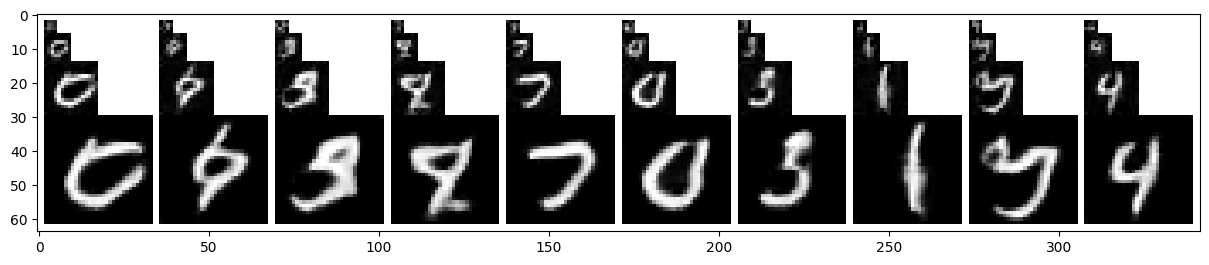

[2023-07-11 17:50:03] Epoch 1


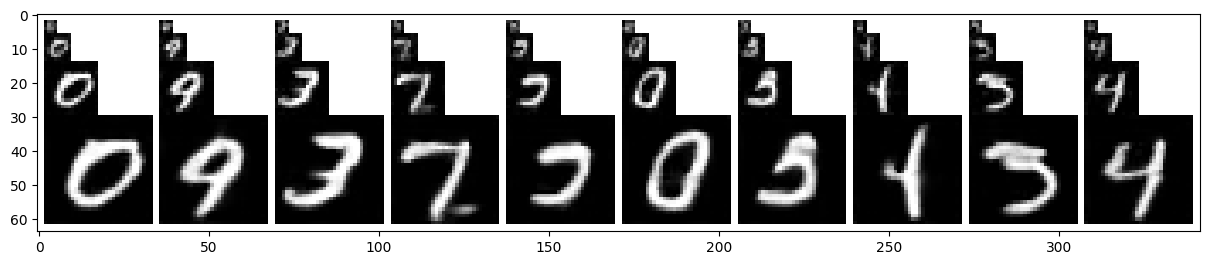

[2023-07-11 17:51:48] Epoch 2


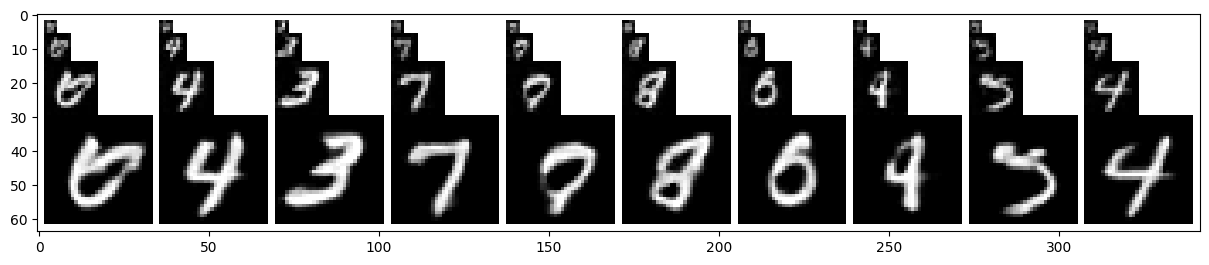

[2023-07-11 17:53:33] Epoch 3


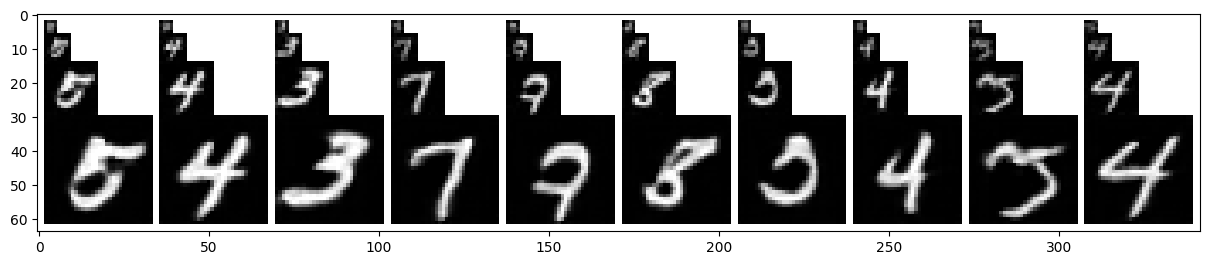

[2023-07-11 17:55:29] Epoch 4


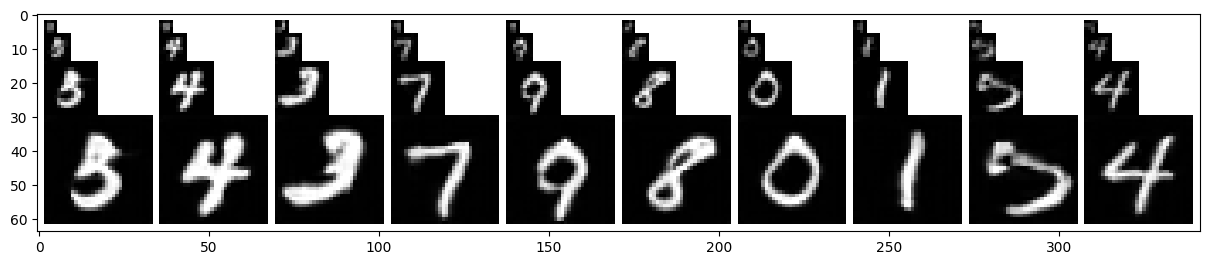

[2023-07-11 17:57:15] Epoch 5


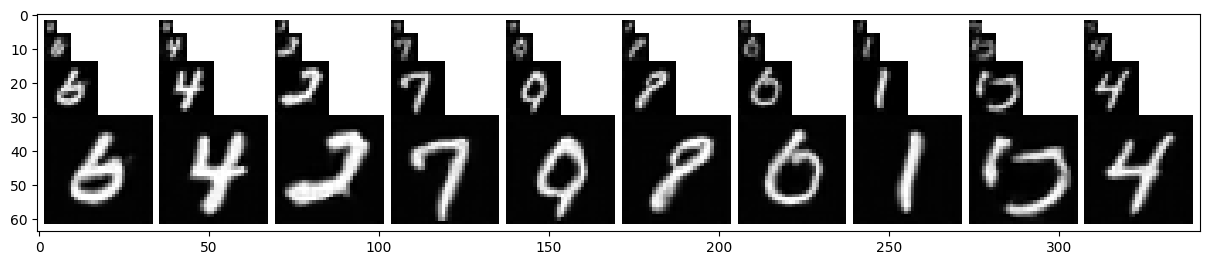

[2023-07-11 17:59:02] Epoch 6


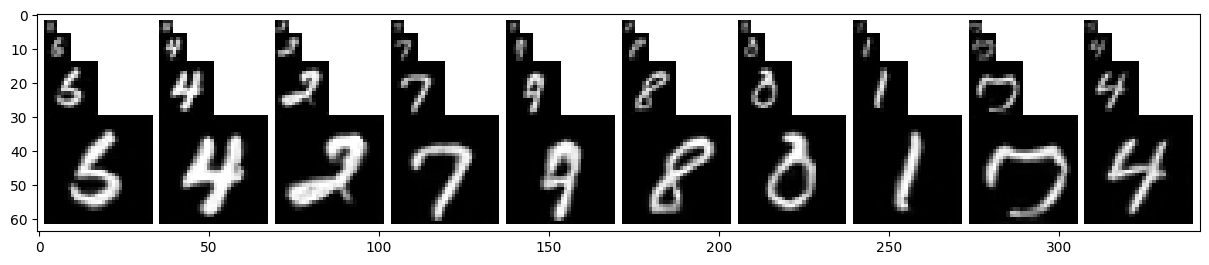

[2023-07-11 18:00:52] Epoch 7


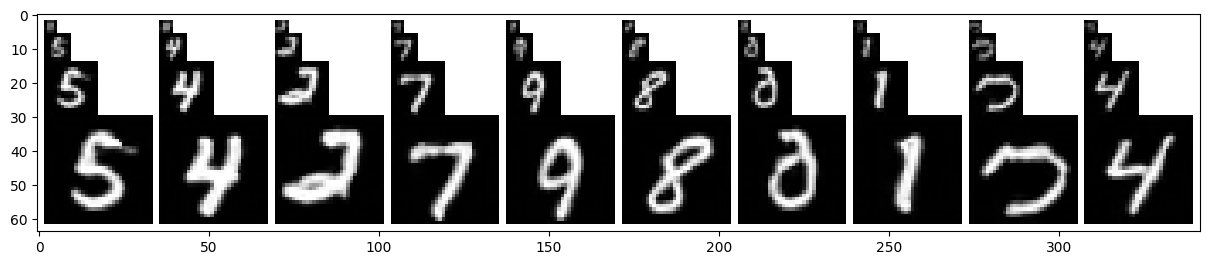

[2023-07-11 18:02:40] Epoch 8


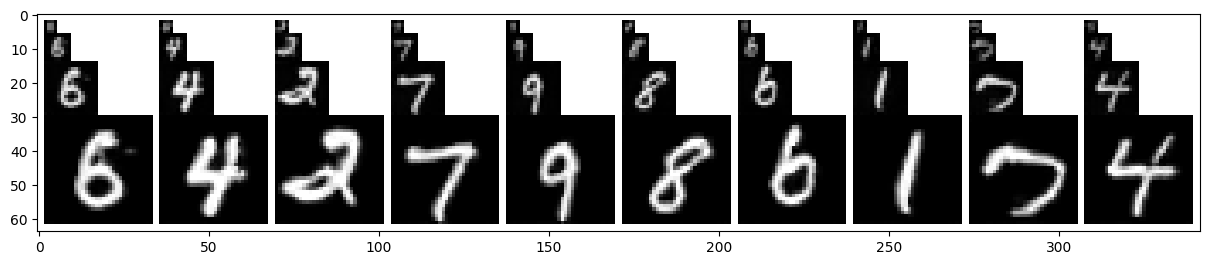

[2023-07-11 18:04:33] Epoch 9


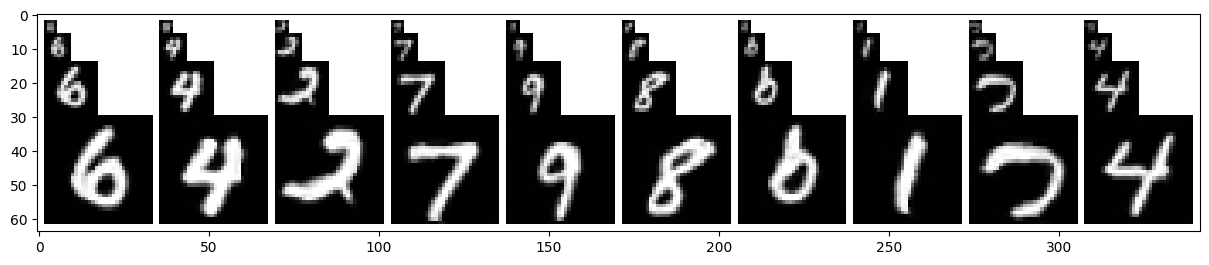

In [17]:
fixed_noise = torch.randn(10, NOISE_DIM, 1, 1).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(NUM_EPOCHS):
    for real_images in dataloader:
        for i in range(len(real_images)):
            real_images[i] = real_images[i].to(device)

        #----- Updating the Discriminator -----#
        for _ in range(NUM_CRITIC_UPDATE):
            noise = torch.randn(real_images[0].shape[0], NOISE_DIM, 1, 1).to(device)
            fake_images = gen(noise)
            for i in range(len(fake_images)):
                fake_images[i] = fake_images[i].detach()
            pred_real, pred_fake = crit(real_images), crit(fake_images)
            loss = -torch.mean(pred_real) + torch.mean(pred_fake) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images, device)
            crit.zero_grad()
            loss.backward(retain_graph=True)
            opt_crit.step()

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        loss = -torch.mean(crit(gen(noise)))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

    # clear_output()
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epoch}")

    imgs = gen(fixed_noise)[:5]
    pyramid_images = [build_pyramid_image(images) for images in zip(*imgs)]
    imgs = torchvision.utils.make_grid(pyramid_images, nrow=len(pyramid_images), pad_value=1).permute(1, 2, 0).numpy()
    plt.figure(figsize=(15, 5))
    plt.imshow(imgs)
    plt.show()

In [19]:
torch.save(gen.state_dict(), 'results_mnist/gen.pth')
torch.save(crit.state_dict(), 'results_mnist/crit.pth')

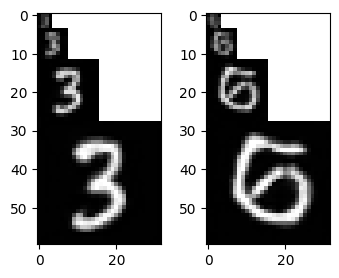

In [21]:
noise = torch.randn(2, NOISE_DIM, 1, 1).to(device)
images = gen(noise)

pyramid_images = [build_pyramid_image(x) for x in zip(*images)]

fig, axs = plt.subplots(1, 2, figsize=(4, 3))
axs[0].imshow(pyramid_images[0].permute(1, 2, 0), cmap="gray")
axs[1].imshow(pyramid_images[1].permute(1, 2, 0), cmap="gray");

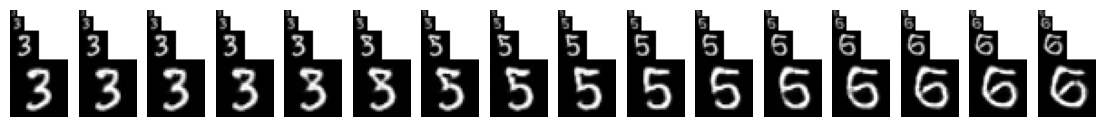

In [22]:
cnt = 15
step = (noise[1] - noise[0]) / cnt
interpolated_noises = []
for i in range(cnt+1):
    interpolated_noises.append(noise[0] + step * i)

interpolated_images = gen(torch.stack(interpolated_noises))

pyramid_images = [build_pyramid_image(x) for x in zip(*interpolated_images)]

fig, axs = plt.subplots(1, cnt+1, figsize=(14, 2))
for i in range(cnt+1):
    axs[i].axis("off")
    axs[i].imshow(pyramid_images[i].permute(1, 2, 0), cmap="gray")